In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import re
import nltk
import pickle
import gensim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score
nltk.download('popular', quiet=True)
wordnet_lemmatizer = WordNetLemmatizer()

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, ReLU
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
import gensim
import pickle

# Sentiment Analysis using BERT

In [4]:
!pip install transformers -q

     |████████████████████████████████| 3.5 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 61.7 MB/s 
     |████████████████████████████████| 6.8 MB 82.6 MB/s 
     |████████████████████████████████| 596 kB 70.5 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 


In [5]:
import tensorflow as tf
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
import pandas as pd
import numpy as np

In [6]:
#Load the amazon_us mobile/electronics product reviews from the TensorFlow database 
#using the ‘tfds‘ API from Tensorflow
import tensorflow_datasets as tfds
ds = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00', split='train', shuffle_files=True)
#convert the dataset into a pandas dataframe
dataset = tfds.as_dataframe(ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0.incomplete7B7LGH/amazon_us_reviews-train.tfrecord


  0%|          | 0/104975 [00:00<?, ? examples/s]

Dataset amazon_us_reviews downloaded and prepared to /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0. Subsequent calls will reuse this data.


In [7]:
dataset.head(3)

,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine
0,b'20980074',0,b'US',b'Mobile_Electronics',b'B00D1847NE',b'274617424',b'Teenage Mutant Ninja Turtles Boombox CD Play...,b'Does not work',b'2015-01-09',b'One Star',b'R1OVS0D6SEXPW7',1,0,0,1
1,b'779273',0,b'US',b'Mobile_Electronics',b'B00KMO6DYG',b'397452138',b'4 Gauge Amp Kit Amplifier Install Wiring Com...,b'This is a great wiring kit i used it to set ...,b'2015-08-06',b'Great kit',b'R9VSD0ET8FERB',4,0,0,1
2,b'15410531',0,b'US',b'Mobile_Electronics',b'B000GWLL0K',b'948304826',b'Travel Wall Charger fits Creative Zen Vision...,b'It works great so much faster than USB charg...,b'2007-03-15',b'A/C Charger for Creative Zen Vision M',b'R3ISXCZHWLJLBH',5,0,0,1


In [8]:
#Label ratings less than or equal to 2 as negative(0), greater than or equal to 4 as 
#positive(2), and ratings equal to 3 as neutral(1), and keep only the review text, 
#the sentiment, and the verified columns Verified purchaces 0(YES), 1(NO)

def preprocess_dataset(df):
  df = df.copy()
  for i,score in zip(df.index.to_list(), df["data/star_rating"].to_list()):
    if score >=4:
      df.loc[i,'sentiment'] = 2
    elif score == 3:
      df.loc[i,'sentiment'] = 1
    else:
      df.loc[i,'sentiment'] = 0
  df["review"] =df["data/review_body"].str.decode("utf-8")
  df["verified"] = df["data/verified_purchase"]
  df["verified"] = df["verified"].map({0:"verified", 1:"not_verified"})
  df = df[["review", "sentiment", "verified"]]
  df[['sentiment']] = df[['sentiment']].astype(int)

  return df

data = preprocess_dataset(dataset)

In [9]:
data['sentiment'].value_counts()

2    70343
0    24898
1     9734
Name: sentiment, dtype: int64

In [ ]:
# Save data sample for future use
#data[["review", "verified"]].sample(300).to_csv("/content/drive/My Drive/winter2022/Projects/SpamReviewsDetector/data/sample_webapp_test.csv", index=False)

In [9]:
[len(data[data['sentiment']==0]), len(data[data['sentiment']==1]), len(data[data['sentiment']==2])]

[24898, 9734, 70343]

In [10]:
#Balance dataset
max_balance = min([len(data[data['sentiment']==0]), len(data[data['sentiment']==1]), len(data[data['sentiment']==2])])
negative_reviews = data[data['sentiment']==0]
neutral_reviews = data[data['sentiment']==1]
positive_reviews = data[data['sentiment']==2]
data = pd.concat([negative_reviews.sample(max_balance), neutral_reviews.sample(max_balance), positive_reviews.sample(max_balance)], ignore_index=True)
data = shuffle(data).reset_index(drop=True)

In [11]:
[len(data[data['sentiment']==0]), len(data[data['sentiment']==1]), len(data[data['sentiment']==2]), len(data)]

[9734, 9734, 9734, 29202]

In [12]:
data[['verified', 'sentiment']].value_counts(normalize=True)

verified      sentiment
verified      1            0.284535
              2            0.282755
              0            0.271454
not_verified  0            0.061879
              2            0.050579
              1            0.048798
dtype: float64

In [13]:
X = data['review'].values.tolist()
y = data['sentiment'].tolist()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)
# 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

In [42]:
#Assign tokenizer object to the tokenizer class
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [16]:
train_encodings = tokenizer(X_train,
                            truncation=True,
                            padding=True)
val_encodings = tokenizer(X_val,
                            truncation=True,
                            padding=True)
train_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(train_encodings),
                            y_train
                            ))
val_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(val_encodings),
                            y_val
                            ))

In [17]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
print(model.summary())

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=2, batch_size=16,
            validation_data=val_dataset.shuffle(1000).batch(16))

Epoch 1/2
1095/1095 [==============================] - 686s 617ms/step - loss: 0.6459 - accuracy: 0.7182 - val_loss: 0.5722 - val_accuracy: 0.7572
Epoch 2/2
1095/1095 [==============================] - 675s 616ms/step - loss: 0.4642 - accuracy: 0.8079 - val_loss: 0.5929 - val_accuracy: 0.7576


In [20]:
# Save model
model.save_pretrained("/content/drive/My Drive/winter2022/Projects/ReviewsPundit/models/final_BERT")

In [40]:
def get_predictions(model, tokenizer, data, labels):
  tf_output = [model.predict(tokenizer.encode(rv, truncation=True, padding=True,return_tensors="tf"))[0] for rv in data]
  tf_prediction = [tf.nn.softmax(itm, axis=1) for itm in tf_output]
  predictions = [labels[tf.argmax(itm, axis=1).numpy()[0]] for itm in tf_prediction]

  return predictions


In [22]:
labels = ['Negative', 'Neutral', 'Positive']
y_pred = get_predictions(model, tokenizer, X_test, labels)
y_real = [labels[i] for i in y_test]

In [23]:
#config = DistilBertConfig.from_json_file("./tf_model/my_tf_model_config.json")
#loaded_model = TFDistilBertForSequenceClassification("/content/drive/My Drive/winter2022/Projects/ReviewsPundit/models/final_BERT/", config=config)

In [24]:
print(classification_report(y_real, y_pred))
print("\n\n Accuracy score  = ", accuracy_score(y_real, y_pred)*100)

              precision    recall  f1-score   support

    Negative       0.82      0.78      0.80      1947
     Neutral       0.66      0.73      0.69      1947
    Positive       0.87      0.80      0.83      1947

    accuracy                           0.77      5841
   macro avg       0.78      0.77      0.77      5841
weighted avg       0.78      0.77      0.77      5841



 Accuracy score  =  77.16144495805513


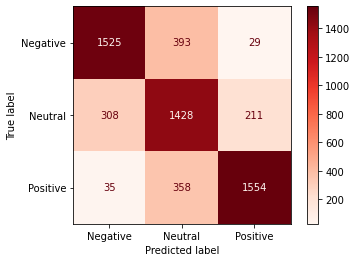

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_real, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Reds')
plt.show()

In [ ]:
test_data = preprocess_dataset(test_dataset)

In [ ]:
# Save data sample for future use
test_data[["review", "verified"]].sample(100000).to_csv("/content/drive/My Drive/winter2022/Projects/SpamReviewsDetector/data/pc_webapp_test.csv", index=False)

In [ ]:
print(classification_report(temp_real, temp_pred))
print("\n\n Accuracy score  = ", accuracy_score(temp_real, temp_pred)*100)

              precision    recall  f1-score   support

    Negative       0.73      0.96      0.83        73
    Positive       0.99      0.89      0.93       227

    accuracy                           0.90       300
   macro avg       0.86      0.92      0.88       300
weighted avg       0.92      0.90      0.91       300



 Accuracy score  =  90.33333333333333


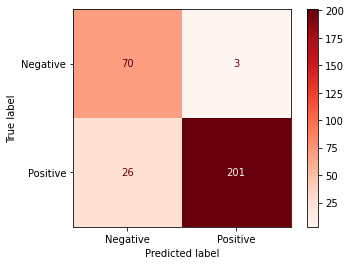

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(temp_real, temp_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Reds')
plt.show()

In [14]:
#Do Lemmatization of a tweet
def normalizer(tweet):
  tweet = re.sub(r"@\S+|https?://\S+", "", tweet).strip()
  alpha_words = re.sub("[^a-zA-Z]", " ", tweet)
  alpha_words = alpha_words.lower()
  alpha_words = alpha_words.split()
  clean = [word.strip() for word in alpha_words if word not in stopwords.words('english')]
  lemmas = [wordnet_lemmatizer.lemmatize(w) for w in clean]
  lemmas = ' '.join(lemmas)
  return lemmas

In [15]:
X = data['review']
X = X.apply(normalizer)
y = data['sentiment']
labels = ['Negative', 'Neutral', 'Positive']

In [16]:
#Remove empty documents after Normalization
empty_docs_idx = [i for i,w in enumerate(X) if w==""]
for i in empty_docs_idx:
  del X[i]
  del y[i]

# 1. Word Embedding with CountVectorizer

In [17]:
#convert each document to a vector of word counts
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_vectorized,y, test_size=0.2)

## a. Logistic Regression

In [18]:
lr_model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
lr_model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [19]:
#Find the best estimators with GridSearch
params = {'C': np.logspace(-3,3,7), "penalty":["l2"]}
gs_clf = GridSearchCV(lr_model, params, n_jobs=-1, cv=10)
gs_clf = gs_clf.fit(X_train, y_train)
lr_model = gs_clf.best_estimator_

In [27]:
y_pred = lr_model.predict(X_test)
y_pred = [labels[i] for i in y_pred]
y_real = [labels[i] for i in y_test]

print(classification_report(y_real, y_pred))
print("\n\n Accuracy score  = ", accuracy_score(y_real, y_pred)*100)

              precision    recall  f1-score   support

    Negative       0.69      0.72      0.70      1932
     Neutral       0.59      0.54      0.56      1954
    Positive       0.73      0.76      0.75      1951

    accuracy                           0.67      5837
   macro avg       0.67      0.67      0.67      5837
weighted avg       0.67      0.67      0.67      5837



 Accuracy score  =  67.22631488778482


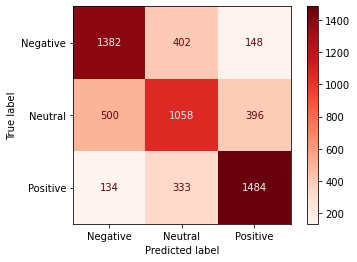

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_real, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Reds')
plt.show()

In [22]:
t1 = ["Meat Week Day 3: Tummy hurts every night"]
test_feature = vectorizer.transform(t1)
print(t1, " ---> ", lr_model.predict(test_feature))
print("\n-----------------------------------------------------\n")

t2 = ["Movie is good"]
test_feature = vectorizer.transform(t2)
print(t2, " ---> ", lr_model.predict(test_feature))
print("\n-----------------------------------------------------\n")

t3 = ["I\'m okay"]
test_feature = vectorizer.transform(t3)
print(t3, " ---> ", lr_model.predict(test_feature))
print("\n-----------------------------------------------------\n")

['Meat Week Day 3: Tummy hurts every night']  --->  [0]

-----------------------------------------------------

['Movie is good']  --->  [1]

-----------------------------------------------------

["I'm okay"]  --->  [1]

-----------------------------------------------------



## b. Naive Bayes

In [33]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB(alpha=1)
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=1)

In [34]:
y_pred = nb_model.predict(X_test)
y_pred = [labels[i] for i in y_pred]
y_real = [labels[i] for i in y_test]

print(classification_report(y_real, y_pred))
print("\n\n Accuracy score  = ", accuracy_score(y_real, y_pred)*100)

              precision    recall  f1-score   support

    Negative       0.69      0.69      0.69      1932
     Neutral       0.58      0.55      0.57      1954
    Positive       0.72      0.74      0.73      1951

    accuracy                           0.66      5837
   macro avg       0.66      0.66      0.66      5837
weighted avg       0.66      0.66      0.66      5837



 Accuracy score  =  66.18125749528868


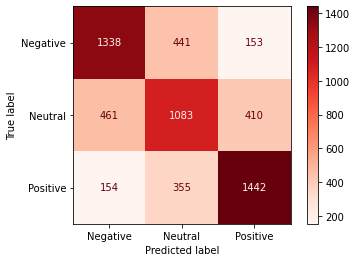

In [35]:
cm = confusion_matrix(y_real, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Reds')
plt.show()

# Test Final Results

In [ ]:
import pandas as pd
import random

filepath = "/content/drive/My Drive/winter2022/Projects/SpamReviewsDetector/data/pc_webapp_test.csv"
df = pd.read_csv(filepath)

In [ ]:
df.sample(100).to_csv("/content/drive/My Drive/winter2022/Projects/SpamReviewsDetector/data/sample_webapp_test.csv", index=False)

In [36]:
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("/content/drive/My Drive/winter2022/Projects/ReviewsPundit/models/final_BERT")

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/My Drive/winter2022/Projects/ReviewsPundit/models/final_BERT.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [37]:
#Load the amazon_us mobile/electronics product reviews from the TensorFlow database 
#using the ‘tfds‘ API from Tensorflow
import tensorflow_datasets as tfds
test_ds = tfds.load('amazon_us_reviews/PC_v1_00', split='train[:10000]')
#convert the dataset into a pandas dataframe
test_dataset = tfds.as_dataframe(ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/amazon_us_reviews/PC_v1_00/0.1.0.incompleteU06Y81/amazon_us_reviews-train.tfrecord


  0%|          | 0/6908554 [00:00<?, ? examples/s]

Dataset amazon_us_reviews downloaded and prepared to /root/tensorflow_datasets/amazon_us_reviews/PC_v1_00/0.1.0. Subsequent calls will reuse this data.


In [47]:
test_data = preprocess_dataset(test_dataset)

In [ ]:
# Save data sample for future use
test_data[["review", "verified"]].sample(100000).to_csv("/content/drive/My Drive/winter2022/Projects/SpamReviewsDetector/data/pc_webapp_test.csv", index=False)

In [50]:
test_data = test_data.sample(6000)
labels = ['Negative', 'Neutral', 'Positive']
temp_pred = get_predictions(loaded_model, tokenizer, test_data['review'].to_list(), labels)
temp_real = [labels[i] for i in test_data['sentiment'].to_list()]

In [51]:
print(classification_report(temp_real, temp_pred))
print("\n\n Accuracy score  = ", accuracy_score(temp_real, temp_pred)*100)

              precision    recall  f1-score   support

    Negative       0.90      0.81      0.85      1455
     Neutral       0.32      0.81      0.46       550
    Positive       0.98      0.80      0.88      3995

    accuracy                           0.81      6000
   macro avg       0.73      0.81      0.73      6000
weighted avg       0.90      0.81      0.84      6000



 Accuracy score  =  80.65


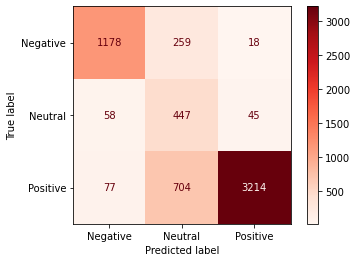

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(temp_real, temp_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Reds')
plt.show()

## Clustering